# Assignment 4 
Understand this example (https://www.tensorflow.org/tutorials/images/transfer_learning#:~:text=A%20pre%2Dtrained%20model%20is,model%20to%20a%20given%20task.) and implement it in a colab notebook (your_name_tl.ipynb).

## Prerequisite

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

## Data preprocessing
### Data download
Download and extract zip file containing the images and create a dataset for training and validation.

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


#### Show first nine images and labels from training set

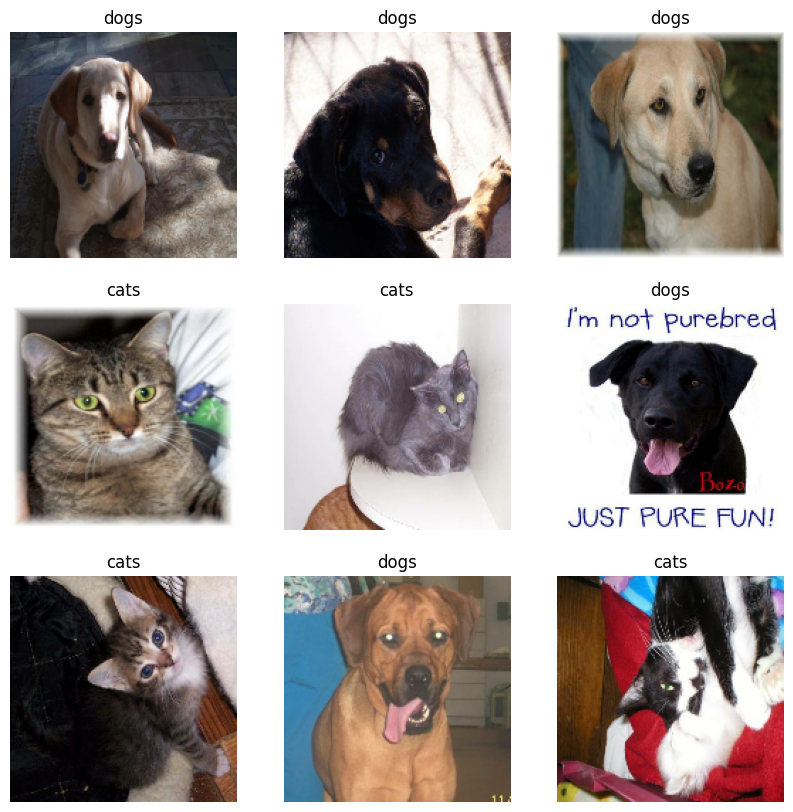

In [3]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Create a test set 
Determine how many batches of data are availablee in the validation set and move 20% to a test set

First calculate the number of batches in the validation set using the tf.data.experimental.cardinality function. 

In [4]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
print('Number of validation batches: %d' % val_batches)

Number of validation batches: 32


Then create a test data set by taking a fraction of the validation dataset. The // 5 means that the new data set will contain one-fifth (20%) of the original validation data set. And update the validation data set by skipping the first val_batches. This results in a validation data set containing the remaining 80% of the original validation data set. 

In [5]:
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of test batches: 6


### Configure the dataset for performance
Use buffered prefetching to load images from disk without having I/O become blocking. TensorFlow's tf.data API to optimize the performance of dataset input pipelines by using the prefetch transformation. Using prefetch(buffer_size=AUTOTUNE) for the train_dataset, validation_dataset, and test_dataset improves the performance of the data input pipeline by overlapping data preprocessing and model execution. This helps in reducing the time taken to load the data, leading to faster training, validation, and testing processes.

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation
Introduce sample diversity by applying random but realistic transformations to the training images such as rotation and horizontal flipping. 

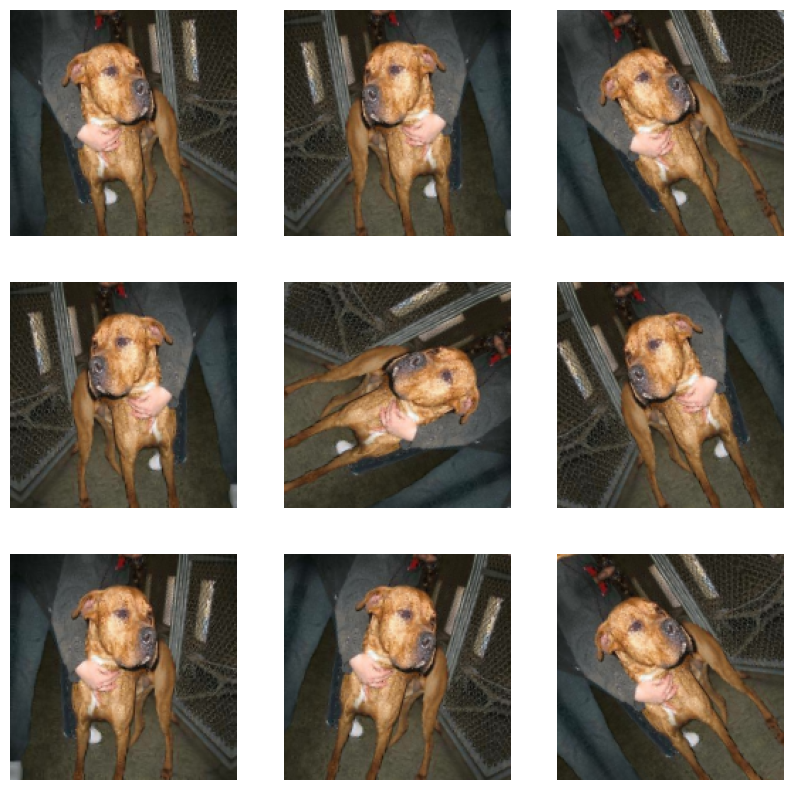

In [7]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values
Rewscale the pixel values from [0, 255] to [-1, 1].  

In [8]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

## Create the base model from the pre-trained convnets
Create the base model from the MobileNet V2 model. First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the include_top=False argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [9]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


### Feature extraction
Freeze the convolutional base before compiling the and training the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training.

In [10]:
base_model.trainable = False
# base_model.summary()

### Add a classification head
To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image.

In [11]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1280)
(32, 1)


Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the Keras Functional API. As previously mentioned, use training=False as our model contains a BatchNormalization layer.

In [13]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Compile the model

In [14]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

## Train the model

In [15]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 428ms/step - accuracy: 0.6013 - loss: 0.6908
initial loss: 0.70
initial accuracy: 0.59


In [16]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 535ms/step - accuracy: 0.5883 - loss: 0.7539 - val_accuracy: 0.8181 - val_loss: 0.4475
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 33s 521ms/step - accuracy: 0.7353 - loss: 0.5356 - val_accuracy: 0.9183 - val_loss: 0.3287
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 462ms/step - accuracy: 0.8065 - loss: 0.4502 - val_accuracy: 0.9332 - val_loss: 0.2651
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 465ms/step - accuracy: 0.8638 - loss: 0.3660 - val_accuracy: 0.9505 - val_loss: 0.2130
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 452ms/step - accuracy: 0.8791 - loss: 0.3245 - val_accuracy: 0.9517 - val_loss: 0.1968
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 458ms/step - accuracy: 0.8904 - loss: 0.2879 - val_accuracy: 0.9616 - val_loss: 0.1658
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 436ms/step - accuracy: 0.8881 - loss: 0.2726 - val_accuracy: 0.9629 - val_loss: 0.1469
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 453ms/step - accuracy: 0.8927 - loss: 0.2655 - val_accu

### Learning curves

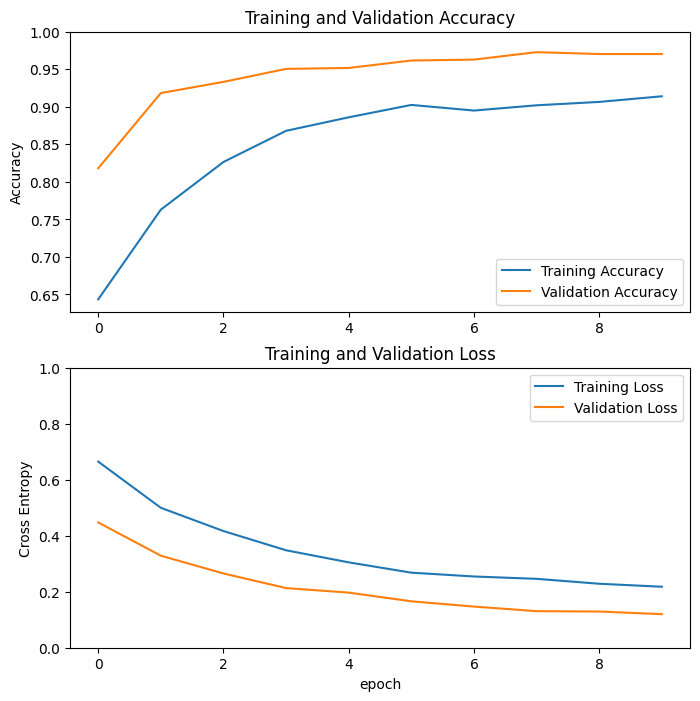

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Fine tuning

First unfreeeze the top layers of the base model

In [18]:
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


### Compile the model
As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [19]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

model.summary()
len(model.trainable_variables)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,862,721 (7.11 MB)

 Non-trainable params: 396,544 (1.51 MB)

56

### Continue training the model

In [20]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset)

Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 68s 795ms/step - accuracy: 0.7503 - loss: 0.4785 - val_accuracy: 0.9802 - val_loss: 0.0770
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 771ms/step - accuracy: 0.8660 - loss: 0.2888 - val_accuracy: 0.9827 - val_loss: 0.0662
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 49s 774ms/step - accuracy: 0.8904 - loss: 0.2487 - val_accuracy: 0.9851 - val_loss: 0.0532
Epoch 14/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 50s 790ms/step - accuracy: 0.9137 - loss: 0.2142 - val_accuracy: 0.9802 - val_loss: 0.0535
Epoch 15/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 47s 753ms/step - accuracy: 0.9390 - loss: 0.1701 - val_accuracy: 0.9851 - val_loss: 0.0468
Epoch 16/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 759ms/step - accuracy: 0.9242 - loss: 0.1719 - val_accuracy: 0.9851 - val_loss: 0.0442
Epoch 17/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 689ms/step - accuracy: 0.9380 - loss: 0.1554 - val_accuracy: 0.9876 - val_loss: 0.0431
Epoch 18/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 688ms/step - accuracy: 0.9456 - loss: 0.1350 - 

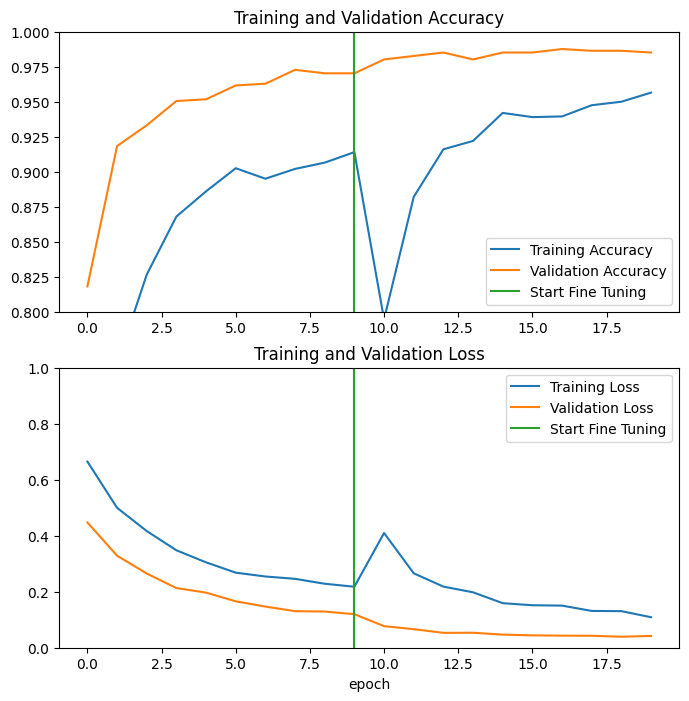

In [21]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

In [22]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 356ms/step - accuracy: 0.9853 - loss: 0.0340
Test accuracy : 0.984375


And now the model is all set to use this model to predict if your pet is a cat or dog.

Predictions:
 [1 0 0 1 0 1 1 1 0 1 1 1 1 0 1 1 1 0 0 0 1 0 1 1 0 1 0 0 0 1 1 0]
Labels:
 [1 0 0 1 0 1 1 1 0 1 1 1 1 0 1 1 1 0 0 0 1 0 1 1 0 1 0 0 0 1 1 0]


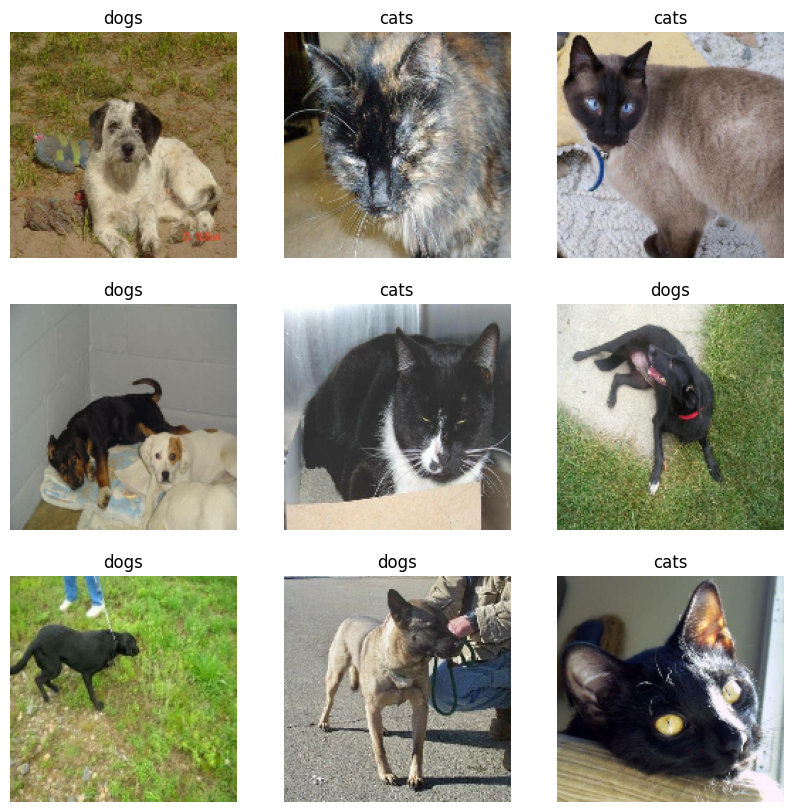

In [23]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## Test with own picture

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


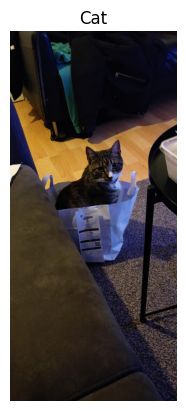

Prediction: Cat


In [29]:
img_path = 'test-image.jpg'

from tensorflow.keras.preprocessing import image

# Function to load and preprocess the image
def load_and_preprocess_image(img_path, target_size=(160, 160)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    return img_array

# Load and preprocess the image
img_array = load_and_preprocess_image(img_path)

# Make a prediction
prediction = model.predict(img_array).flatten()

# Convert prediction to binary (0 or 1)
prediction = tf.where(prediction < 0.5, 0, 1).numpy()

# Display the image and prediction result
plt.imshow(image.load_img(img_path))
plt.title('Cat' if prediction == 0 else 'Dog')
plt.axis("off")
plt.show()

print('Prediction:', 'Cat' if prediction == 0 else 'Dog')